In [0]:
import os
import cv2
import numpy as np
import random
#!pip install Image
#import Image
from PIL import Image
from PIL import ImageOps
from google.colab import drive

In [0]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
print(os.listdir("/content/gdrive/My Drive/Pneumonia/chest_xray"))

['val', 'train', 'test', '.DS_Store']


In [0]:
random.seed( 101 )

In [0]:
# Load and augment training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255, 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/My Drive/Pneumonia/chest_xray/train',
    batch_size=16,
    target_size=(128, 128),
    shuffle=True,
    class_mode='categorical'
)

Found 5216 images belonging to 2 classes.


In [0]:
# Load validation and test data
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(
    '/content/gdrive/My Drive/Pneumonia/chest_xray/val',
    batch_size=16,
    target_size=(128, 128),
    class_mode='categorical'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
    '/content/gdrive/My Drive/Pneumonia/chest_xray/test',
    batch_size=16,
    target_size=(128, 128),
    class_mode='categorical'
)

Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
# Use MobileNetV2 as base model for transfer learning
base_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)
base_model.trainable = False

W0813 00:36:13.596106 139623076452224 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


80142336/80134624 [==============================] - 4s 0us/step


In [0]:
# Define model
def model():
    model = base_model.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dense(units=512, activation='relu')(model)
    model = tf.keras.layers.Dropout(0.7)(model)
    predictions = tf.keras.layers.Dense(units=2, activation='softmax')(model)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    return model

In [0]:
model = model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0813 00:36:28.099004 139623076452224 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [0]:
Log = model.fit_generator(
    train_generator,
    epochs=20,
    verbose=1,
    validation_data=val_generator,
)

Epoch 1/20
326/326 [==============================] - 1708s 5s/step - loss: 0.3611 - acc: 0.8326 - val_loss: 0.4873 - val_acc: 0.8125
Epoch 2/20
326/326 [==============================] - 1140s 3s/step - loss: 0.2600 - acc: 0.8825 - val_loss: 0.4289 - val_acc: 0.8750
Epoch 3/20
326/326 [==============================] - 1150s 4s/step - loss: 0.2432 - acc: 0.8924 - val_loss: 0.5037 - val_acc: 0.8125
Epoch 4/20
326/326 [==============================] - 1144s 4s/step - loss: 0.2328 - acc: 0.9030 - val_loss: 0.4754 - val_acc: 0.8125
Epoch 5/20
326/326 [==============================] - 1144s 4s/step - loss: 0.2308 - acc: 0.9016 - val_loss: 0.5471 - val_acc: 0.8125
Epoch 6/20
326/326 [==============================] - 1147s 4s/step - loss: 0.2075 - acc: 0.9135 - val_loss: 0.6532 - val_acc: 0.8125
Epoch 7/20
326/326 [==============================] - 1146s 4s/step - loss: 0.2135 - acc: 0.9149 - val_loss: 0.5674 - val_acc: 0.8125
Epoch 8/20
326/326 [==============================] - 1140s 3s

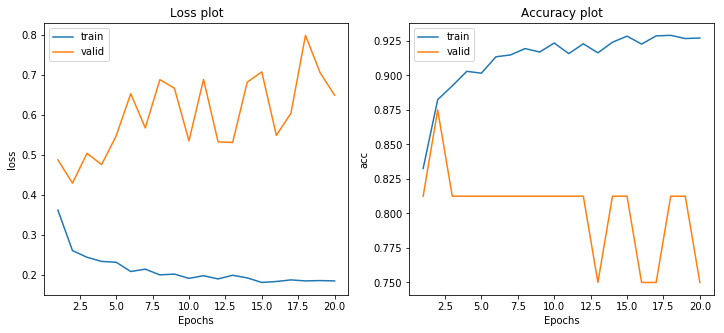

In [0]:
# plot the model loss and accuracy
train_loss = Log.history['loss']
train_acc = Log.history['acc']

valid_loss = Log.history['val_loss']
valid_acc = Log.history['val_acc']

x = [(i+1) for i in range(len(train_loss))]

f,ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(x, train_loss)
ax[0].plot(x, valid_loss)
ax[0].set_title("Loss plot")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'valid'])


ax[1].plot(x, train_acc)
ax[1].plot(x, valid_acc)
ax[1].set_title("Accuracy plot")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("acc")
ax[1].legend(['train', 'valid'])

plt.show()

In [0]:
loss, test_acc = model.evaluate_generator(
    test_generator,
    steps=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True,
    verbose=1
)

print(test_acc)

39/39 [==============================] - 176s 5s/step - loss: 0.3359 - acc: 0.8878
0.88782054


In [0]:
model.save('model.h5')

In [0]:
# Load model for testing
model = tf.keras.models.load_model('model.h5')

test_dir = Path('/content/gdrive/My Drive/Pneumonia/chest_xray/test')

normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

W0813 08:27:19.989789 139623076452224 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0813 08:27:19.992980 139623076452224 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0813 08:27:20.345756 139623076452224 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [0]:

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128, 128))
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = tf.keras.utils.to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128, 128))
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = tf.keras.utils.to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 128, 128, 3)
Total number of labels: (624, 2)


<Figure size 432x288 with 0 Axes>

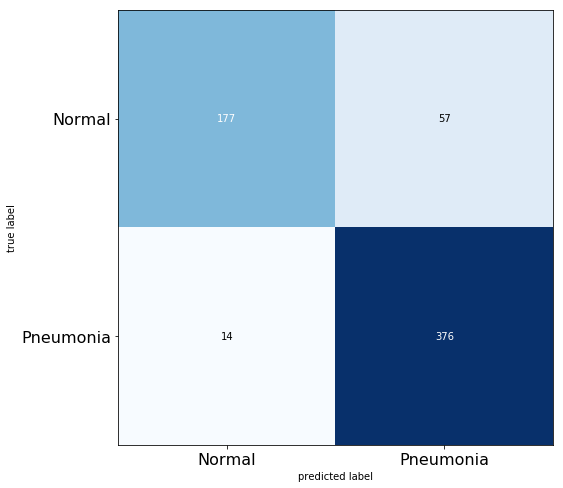

Recall of the model is 0.96
Precision of the model is 0.87


In [0]:
# Get predictions
preds = model.predict(test_data, batch_size=16)#<-
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

cm = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True,
                      cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))